In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Optional
from typing_extensions import TypedDict

from lightgbm import LGBMRegressor
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from mapie.metrics import regression_coverage_score, regression_mean_width_score

from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from scipy.stats import randint, uniform

round_to = 3
random_state = 5
rng = np.random.default_rng(random_state)


In [2]:
def sort(y_test, y_pred, y_pis):
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot(title, y_test_sorted, y_pred_sorted, lower_bound, upper_bound, coverage, num_plots_idx):
    fig, axs = plt.subplots(figsize=(9, 6))
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f'+"k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'+"k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    axs.set_xlabel("x")
    axs.set_ylabel("y")
    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(y_test_sorted_[~warnings], y_pred_sorted_[~warnings], yerr=error[~warnings], capsize=5, marker="o", elinewidth=2, linewidth=0)
    axs.errorbar(y_test_sorted_[warnings], y_pred_sorted_[warnings], yerr=error[warnings], capsize=5, marker="o", elinewidth=2, linewidth=0, color="red")
    axs.scatter(y_test_sorted_[warnings], y_test_sorted_[warnings], marker="*", color="green")
    
    axs.set_xlabel("Actual house price $")
    axs.set_ylabel("Predicted house price $")
    axs.set_title(f"{title}\nCoverage of: {coverage}")
    plt.show()

# Data

In [3]:
# data = pd.read_csv("housing_data.csv")
# data = data.drop(["Id"], axis=1)
# data = data.dropna(axis=1)
# data.drop(data[data.SalePrice > np.quantile(data.SalePrice, 0.95)].index, inplace=True)
# X = data.drop(["SalePrice"], axis=1)
# y = data["SalePrice"]/1000

In [4]:
import warnings
from sklearn.datasets import load_boston
with warnings.catch_warnings():
    # You should probably not use this dataset.
    warnings.filterwarnings("ignore")
    X, y = load_boston(return_X_y=True)
X = pd.DataFrame(X)

In [5]:
X[X.select_dtypes(include=["object"]).columns] = X[X.select_dtypes(include=["object"]).columns].astype("category")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, random_state=random_state)

# Optimizing

Optimization of the `LGBMRegressor` using `RandomizedSearchCV` to find the optimal model to predict the house prices.

In [6]:
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state)
params_distributions = dict(
    num_leaves = randint(low=10, high=50),
    max_depth = randint(low=3, high=20),
    n_estimators = randint(low=50, high=300),
    learning_rate = uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator = estimator.set_params(**optim_model.best_params_)

# Comparaison

Compairing the differents regression methods available in MAPIE.

In [7]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, str], "alpha": Optional[float]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "jackknife_plus": Params(method="plus", cv=-1),
    "cv_plus": Params(method="plus", cv=10),
    "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.1)
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.1)
    y_test_sorted[strategy], y_pred_sorted[strategy], lower_bound[strategy], upper_bound[strategy] = sort(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = np.round(regression_coverage_score(y_test, y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]), round_to)
    width[strategy] = np.round(regression_mean_width_score(y_pis[strategy][:, 0, 0], y_pis[strategy][:, 1, 0]))


/Users/llacombe/CODE/MAPIE/mapie/utils.py:466: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/CODE/MAPIE/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


In [8]:
perc_obs_plot = 0.25
num_plots = index = rng.choice(len(y_test), int(perc_obs_plot*len(y_test)), replace=False)

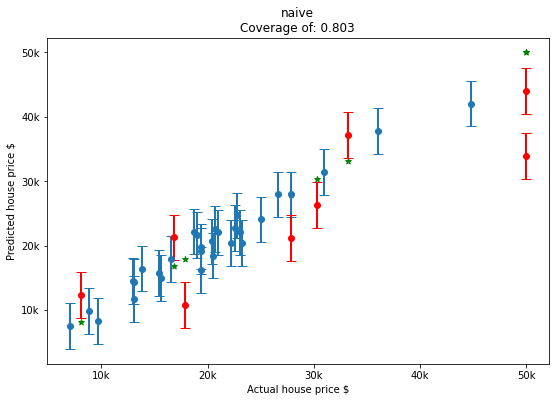

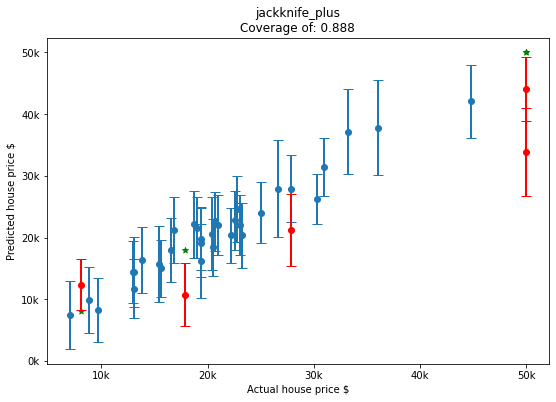

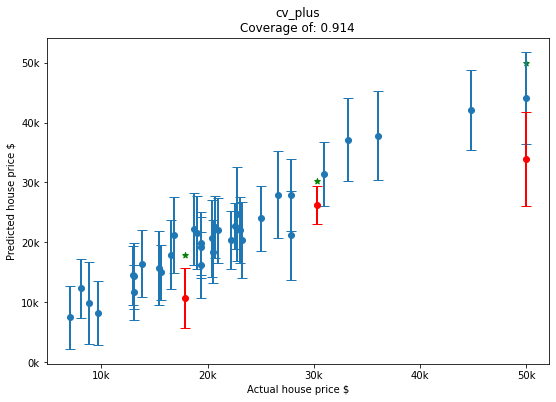

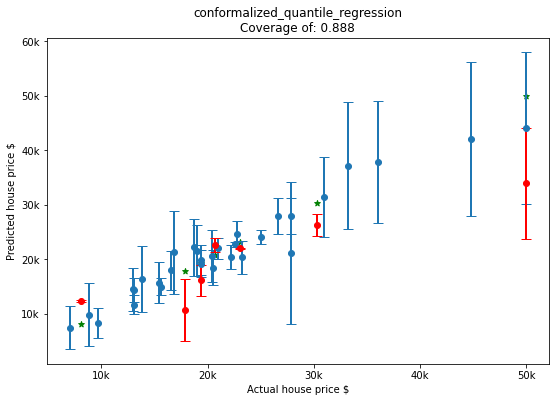

In [9]:
for item in STRATEGIES:
    plot(item, y_test_sorted[item], y_pred_sorted[item], lower_bound[item], upper_bound[item], coverage[item], num_plots)

We notice more adaptability of the prediction intervals for the conformalized quantile regression while the other methods have fixed interval width.

In [10]:
def get_bins(want, y_test, y_pred, lower_bound, upper_bound, STRATEGIES, bins):
    cuts = []
    cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test["naive"])+1)
    recap ={}
    for i in range(len(cuts)-1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 0)}, {np.round(cut2, 0)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where((y_test[strategy]>cut1)*(y_test[strategy]<=cut2))
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want=="coverage":
                recap[name].append(regression_coverage_score(y_test_trunc[0], y_low_[0], y_high_[0]))
            elif want=="width":
                recap[name].append(regression_mean_width_score(y_low_[0], y_high_[0]))
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df

In [11]:
bins = list(np.arange(0, 1, 0.1))
binned_data = get_bins("coverage", y_test_sorted, y_pred_sorted, lower_bound, upper_bound, STRATEGIES, bins)

To confirm this insights, we will now observe what happens when we plot the conditional coverage and interval width on these intervals.

<Figure size 432x288 with 0 Axes>

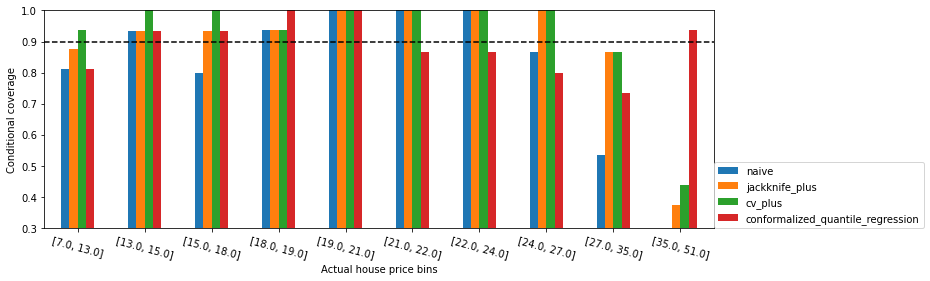

In [12]:
fig = plt.figure()
binned_data.T.plot.bar(figsize=(12, 4))
plt.axhline(0.90, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.xlabel("Actual house price bins")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])

What we observe from these results is that none of the methods seems to have conditional coverage. It is however suprising to see that the conformalized quantile regression does not outperform the other methods.

In [13]:
binned_data = get_bins("width", y_test_sorted, y_pred_sorted, lower_bound, upper_bound, STRATEGIES, bins)

<Figure size 432x288 with 0 Axes>

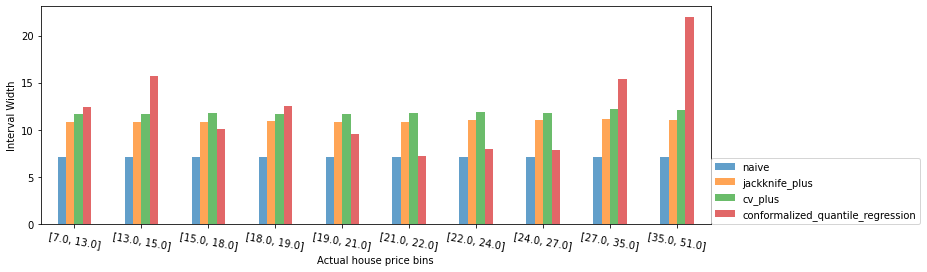

In [14]:
fig = plt.figure()
binned_data.T.plot.bar(figsize=(12, 4), alpha=0.7)
plt.ylabel("Interval Width")
plt.xlabel("Actual house price bins")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])

When observing the values of the the interval width we again see what was observed in the previous graphs with the interval widths. We can again see that the prediction intervals are larger as the price of the houses increases, interestingly, it's important to note that the prediction intervals are shorter when the estimator is more certain as can be observed in the intervals: .